# MIDS W261 HW9

## HW 9.0: Short answer questions

What is PageRank and what is it used for in the context of web search?  






What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to 
compute the steady stade distibuton? 








**OPTIONAL:** In topic-specific pagerank, how can we insure that the irreducible property is satified? (HINT: see HW9.4)

## HW 9.1: MRJob implementation of basic PageRank

Write a basic MRJob implementation of the iterative PageRank algorithm that takes sparse adjacency lists as input (as explored in HW 7). Make sure that your implementation utilizes teleportation ( $\frac{1-damping}{nodes}$ ), and further, distributes the mass of dangling nodes with each iteration so that the output of each iteration is correctly normalized (sums to 1).

[**NOTE:** The PageRank algorithm assumes that a random surfer (walker), starting from a random web page, chooses the next page to which it will move by clicking at random, with probability $d$, one of the hyperlinks in the current page. This probability is represented by a so-called ‘damping factor’ $d$, where $d \in (0, 1)$. Otherwise, with probability $(1 − d)$, the surfer jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform distribution and “teleports” to that page]


As you build your code, use the test data

s3://ucb-mids-mls-networks/PageRank-test.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name. 
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck
your work with the true result, displayed in the first image in the Wikipedia article:

https://en.wikipedia.org/wiki/PageRank

and here for reference are the corresponding PageRank probabilities:

| Node | Pr |
|-----|------|
| A | 0.033 |
| B | 0.384 |
| C | 0.343 |
| D | 0.039 |
| E | 0.081 |
| F | 0.039 |
| G | 0.016 |
| H | 0.016 |
| I | 0.016 |
| J | 0.016 |
| K | 0.016 |

In [1]:
# Jupyter requires this for MRJob to reload classes properly
%load_ext autoreload
%autoreload 2
%matplotlib inline

/Users/rcordell/Documents/MIDS/W261/W261env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [216]:
%%writefile MrJobTransform91.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import numpy as np

import re
#
# Visit all nodes of the graph to calculate the minimum distance of the graph 
#         
class MrJobTransform91(MRJob):

    def configure_options(self):
        super(MrJobTransform91, self).configure_options()    
    
    # each line is from the adjacency list node_id \t {neighbor: weight}
    # where {neighbor:weight} is one of m elements in the dictionary
    # emit node \t [page_rank, num_outlinks, [outlinks]]
    def mapper(self, _, line):
        node, adj_list = re.split('\t',line.strip())
        node = node.strip('"')
        neighbors = eval(adj_list)
        yield node, [0.0, neighbors.keys()]
        yield '*', [node]
        yield '*', neighbors.keys()
        

    def reducer_init(self):
        self.nodes = []
        self.init_page_rank = 0.0
        
        
    # node, [page_rank, num_outlinks, [outlinks]]
    # OR
    # count, [node]
    def reducer(self, node, neighbors):
        # we should get all the counts first
        if node == '*':
            for neighbor in neighbors:
                for neighbor_node in neighbor:
                    if neighbor_node not in self.nodes:
                        self.nodes.append(neighbor_node)
                        self.increment_counter('transformer', 'nodes', 1)
            self.init_page_rank = 1.0/len(self.nodes)

        else:
            # not an integer but a node name
            self.nodes.remove(node)
            for page_rank, outlinks in neighbors:
                yield node, [self.init_page_rank, outlinks]

    # if there are any nodes that have not been emitted, emit them
    # now with an empty outlink list
    def reducer_final(self):
        for node in self.nodes:
            yield node, [self.init_page_rank, []]


    def steps(self):
        return [MRStep(mapper=self.mapper,
                       reducer_init=self.reducer_init,
                       reducer=self.reducer,
                       reducer_final=self.reducer_final,
                       jobconf = {
                        'mapred.map.tasks' : 28,
                        'mapred.reduce.tasks' : 1
                    })]
    
if __name__ == '__main__':
    MrJobTransform91.run()

Overwriting MrJobTransform91.py


In [217]:
from MrJobTransform91 import MrJobTransform91
              
def transform(qfile):
    mr_job = MrJobTransform91(args=[qfile, '-r','hadoop'])

    more_nodes_to_visit = True
    with open('pagerank_in.txt','w') as rankfile:
        while(more_nodes_to_visit):
            with mr_job.make_runner() as runner:
                runner.run()
                more_nodes_to_visit = False
                for line in runner.stream_output():
                    q = mr_job.parse_output_line(line)
                    rankfile.write(line)
                counters = runner.counters()
                print 'Node Count: {0}'.format(counters[0]['transformer']['nodes'])

        
if __name__ == '__main__':
    transform('Data/wikipedia/test-out.txt')

Node Count: 161019


In [43]:
%%writefile MrJob91.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import numpy as np
import types

import re
       
class MrJob91(MRJob):

    def configure_options(self):
        super(MrJob91, self).configure_options()    
        self.add_passthrough_option(
            '--nodes', dest='nodes', type='int', default=0, 
            help="Number of nodes")    
        self.add_passthrough_option(
            '--damping', dest='damping', type='float', default=0.85, 
            help="damping factor") 
        
    def pr_mapper(self, _, line):
        node, value_list = re.split('\t',line.strip())
        node = node.strip('"')
        v = eval(value_list)
        # yield the graph structure
        yield node, [0.0, v[1]]
        
        # distrubute the rank to all the outlink nodes
        if len(v[1]) > 0:
            for outlink in v[1]:
                yield outlink, v[0]/len(v[1])
        else:
            # this takes care of mass that doesn't get propogated when 
            # there are no outlink nodes to distribute it to
            yield node, v[0]
            
    def pr_reducer_init(self):
        self.pr_mass = 0.0
        
    # node_id \t page_rank 
    # OR
    # node_id \t [page_rank, [outlinked nodes]]
    def pr_reducer(self, node, neighbors):
        adj_list = []
        rank = 0.0
        for neighbor in neighbors:
            if isinstance(neighbor, list):
                # this is the graph
                adj_list = neighbor
            else:
                rank += neighbor
        self.pr_mass += rank
        yield node, [rank, adj_list[1]]
   
    def pr_reducer_final(self):
#        print '-',self.pr_mass
        pass

    # find the dangling nodes and emit their mass with the key '*'
    def dangling_mapper(self, node, rank):
        if len(rank[1]) == 0:            
            yield '*', rank[0]
            yield node, [0.0, rank[1]]
        else:
            yield node, rank
            
    
    def dangling_reducer_init(self):
        self.conserved_mass = 0.0
        self.mass = 0.0
        
    # sum the dangling node mass
    def dangling_reducer(self, key, mass):
        if key == '*':
            self.conserved_mass = sum(mass)
        else:
            # distrubute the conserved mass
            # mass is really [rank, count, [outlinks]] in this case
            distributed_mass = self.conserved_mass/self.options.nodes
            teleport_prob = (1.0-self.options.damping)/self.options.nodes
            for item in mass:
                new_rank = teleport_prob + (self.options.damping*(item[0] + distributed_mass))
                self.mass += new_rank
                yield key, [new_rank, item[1]]
    
    def dangling_reducer_final(self):
#        print '*',self.mass
        pass

            

    def steps(self):
        return [MRStep(mapper=self.pr_mapper,
                       reducer_init=self.pr_reducer_init,
                       reducer=self.pr_reducer,
                       reducer_final=self.pr_reducer_final), 
                MRStep(mapper=self.dangling_mapper,
                       reducer_init=self.dangling_reducer_init,
                       reducer=self.dangling_reducer,
                       reducer_final=self.dangling_reducer_final)] 
    
if __name__ == '__main__':
    MrJob91.run()

Overwriting MrJob91.py


In [179]:
%%writefile driver91.py
from MrJob91 import MrJob91
from shutil import copyfile
from MrJobTransform91 import MrJobTransform91
import sys

if len(sys.argv) > 1:
    try:
        d = float(sys.argv[1])
    except:
        d = 0.85
else:
    d = 0.85
    
print 'Damping Factor {0:0.2f}'.format(d)

def transform(adj_list, outfile):
    mr_job = MrJobTransform91(args=[adj_list])

    more_nodes_to_visit = True
    with open(outfile,'w') as rankfile:
        while(more_nodes_to_visit):
            with mr_job.make_runner() as runner:
                runner.run()
                more_nodes_to_visit = False
                for line in runner.stream_output():
                    q = mr_job.parse_output_line(line)
                    rankfile.write(line)
                counters = runner.counters()
                return counters[0]['transformer']['nodes']
    
def page_rank(infile, outfile, node_count, damping_factor):
    mr_job = MrJob91(args=[infile,
                          '--nodes', str(node_count),
                          '--damping', str(damping_factor)])

    more_nodes_to_visit = True
    with open(outfile,'w') as rankfile:
        while(more_nodes_to_visit):
            with mr_job.make_runner() as runner:
                runner.run()
                more_nodes_to_visit = False
                for line in runner.stream_output():
                    q = mr_job.parse_output_line(line)
                    rankfile.write(line)

def driver(infile, outfile, damping_factor):
    # transform the adjacency list first and get the total number of nodes
    num_nodes = transform('Data/PageRank-test.txt','pagerank_in.txt')
    
    iterations = 0     
    while iterations < 50:
        page_rank(infile, outfile, num_nodes, damping_factor)
        copyfile(outfile, infile)
        iterations += 1
#        print 'Iteration: {0}'.format(iterations)  
        
if __name__ == '__main__':
    driver('pagerank_in.txt','pagerank_out.txt', d)

Overwriting driver91.py


In [182]:
!python driver91.py 0.85

Damping Factor 0.85


## HW 9.2: Exploring PageRank teleportation and network plots
In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. 
Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha,
so that each nodes radius is proportional to its PageRank score. In particular you should
do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1]. Note your plots should look like the following:

https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg

In [194]:
import networkx as nx
import matplotlib.pyplot as plt
import re

def draw_graph():
    G = nx.DiGraph()

    with open('pagerank_out.txt','r') as rankfile:
        for line in rankfile.readlines():
            node_, rank_outlinks = re.split('\t', line.strip())
            node = node_.strip('"')
            rank_and_outlinks = eval(rank_outlinks)
            G.add_node(node)
            G.node[node]['rank'] = rank_and_outlinks[0]
            for outlink in rank_and_outlinks[1]:
                G.add_node(outlink)
                G.add_edge(node, outlink)

    labels = {}
    ranks = []
    for node in G.node:
        labels[node]='{0}\n{1:2.2f}%'.format(node, 100*G.node[node]['rank'])
        ranks.append(100*G.node[node]['rank'])

    fig = plt.figure(figsize=(12,12))

    #pos = {'A': [ 8.,  2.],
    #             'C': [ 2.,  1.], 
    #             'B': [ 1.6,  9.], 
    #             'E': [ 6.5,  8.], 
    #             'D': [ 5.,  1.],
    #             'G': [ 5.,  6.5], 
    #             'F': [ 5.,  9.], 
    #             'I': [ 6.,  11.],
    #             'H': [ 5.,  5.], 
    #             'K': [ 7.5,  9.],
    #             'J': [ 8.,  8.]}

    pos=nx.spring_layout(G, k=5.0)

    nx.draw(G, pos, with_labels=True, arrows=True, labels=labels,
            node_size=[200000*G.node[node]['rank'] for node in G.node],
            vmin=min([G.node[node]['rank'] for node in G.node]),
            vmax=max([G.node[node]['rank'] for node in G.node]),
            node_color=[G.node[node]['rank'] for node in G.node],
            cmap=plt.cm.Set1)
    plt.show()
        

In [196]:
!python driver91.py 0.0

Damping Factor 0.00


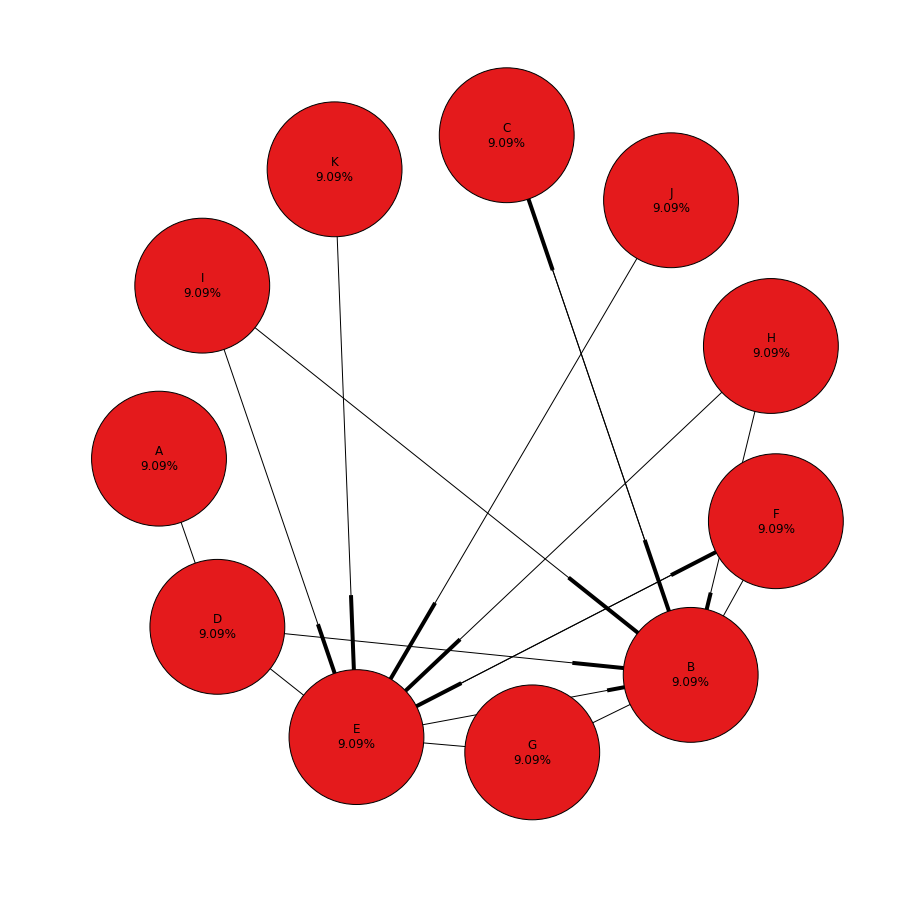

In [197]:
draw_graph()

In [198]:
!python driver91.py 0.25

Damping Factor 0.25


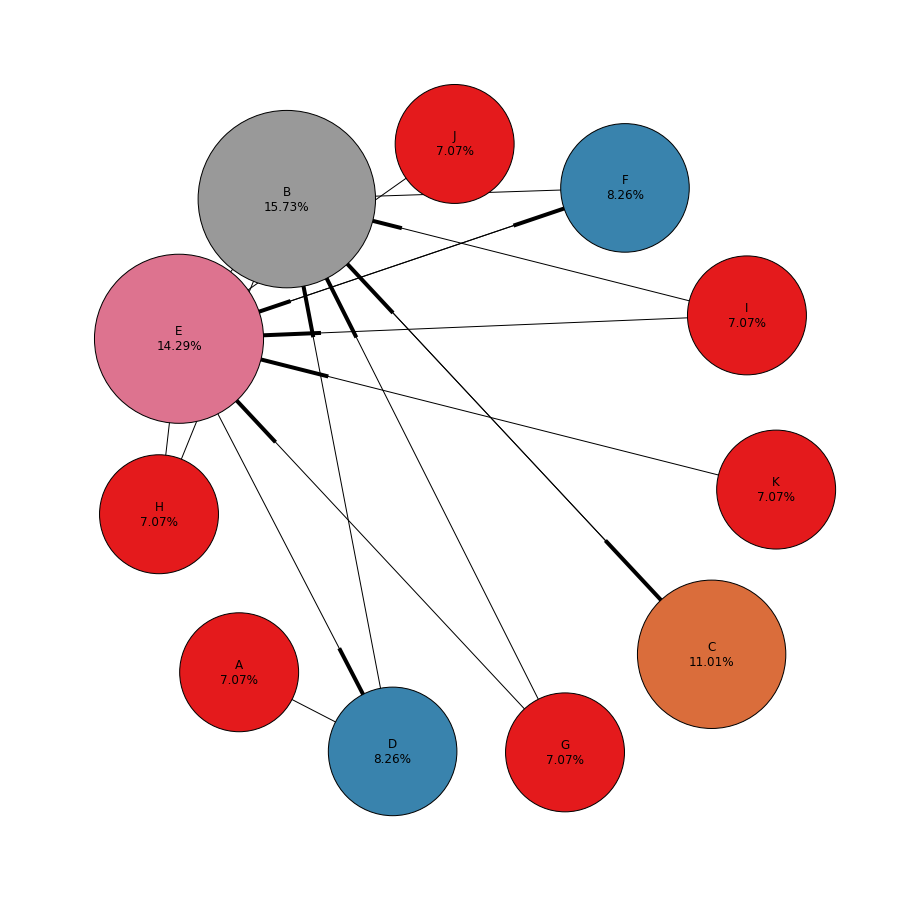

In [199]:
draw_graph()

In [200]:
!python driver91.py 0.5

Damping Factor 0.50


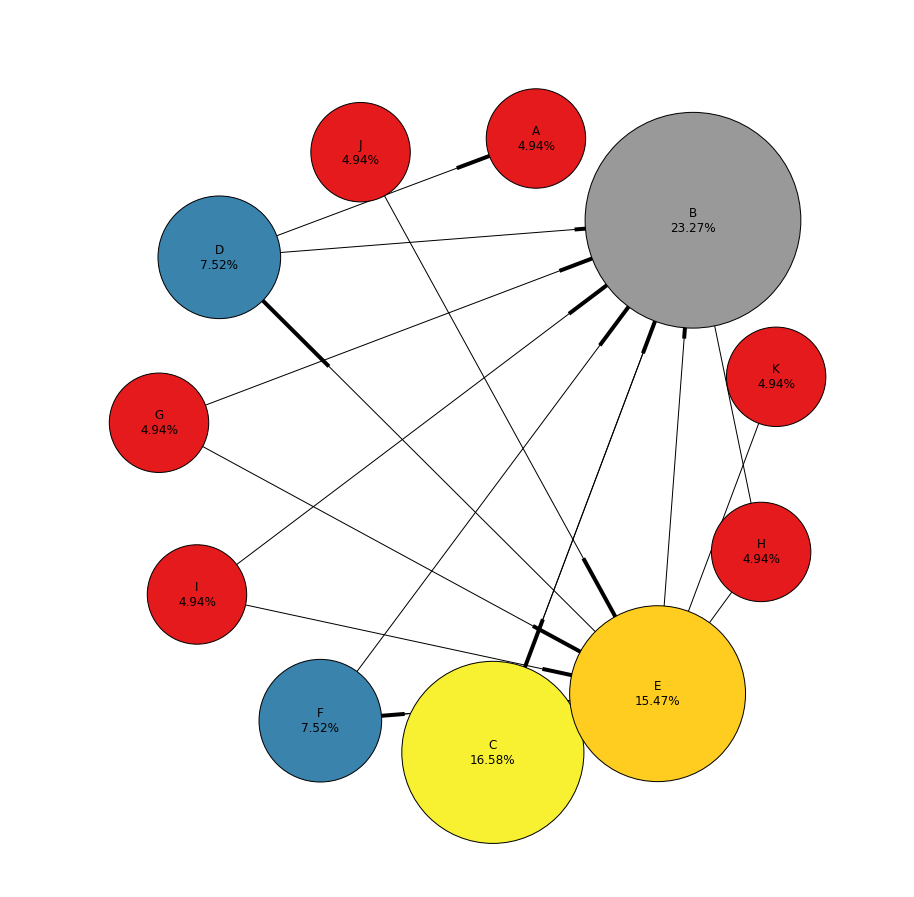

In [201]:
draw_graph()

In [202]:
!python driver91.py 0.75

Damping Factor 0.75


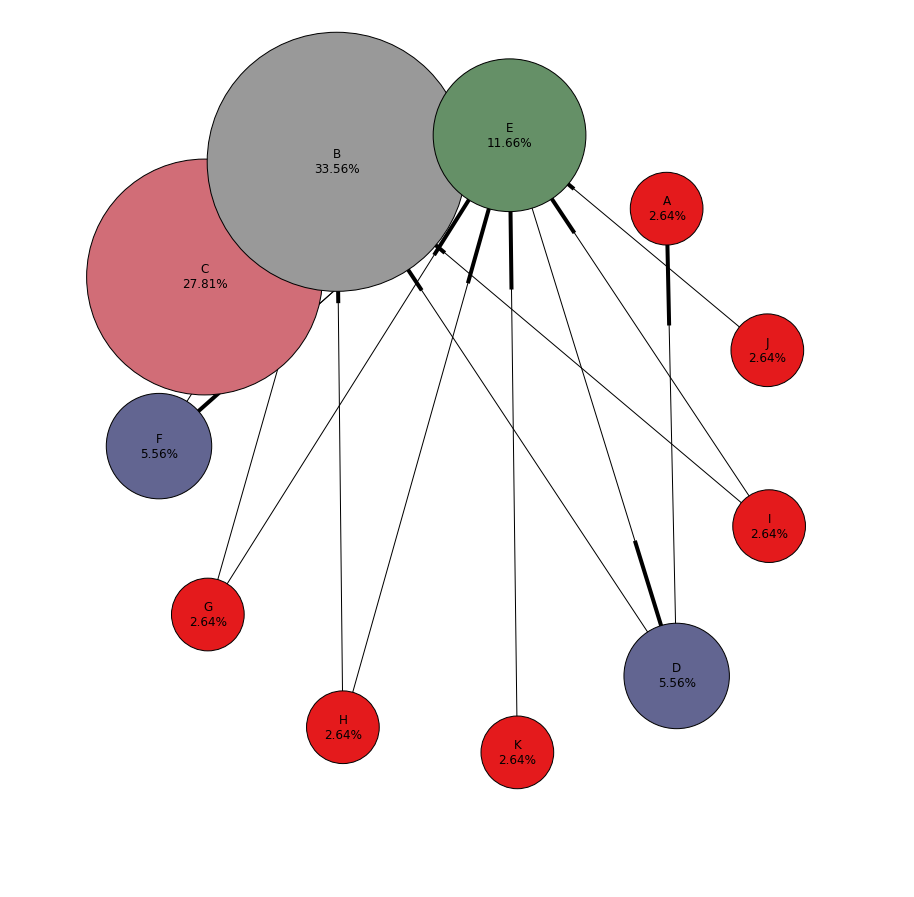

In [203]:
draw_graph()

In [204]:
!python driver91.py 0.85

Damping Factor 0.85


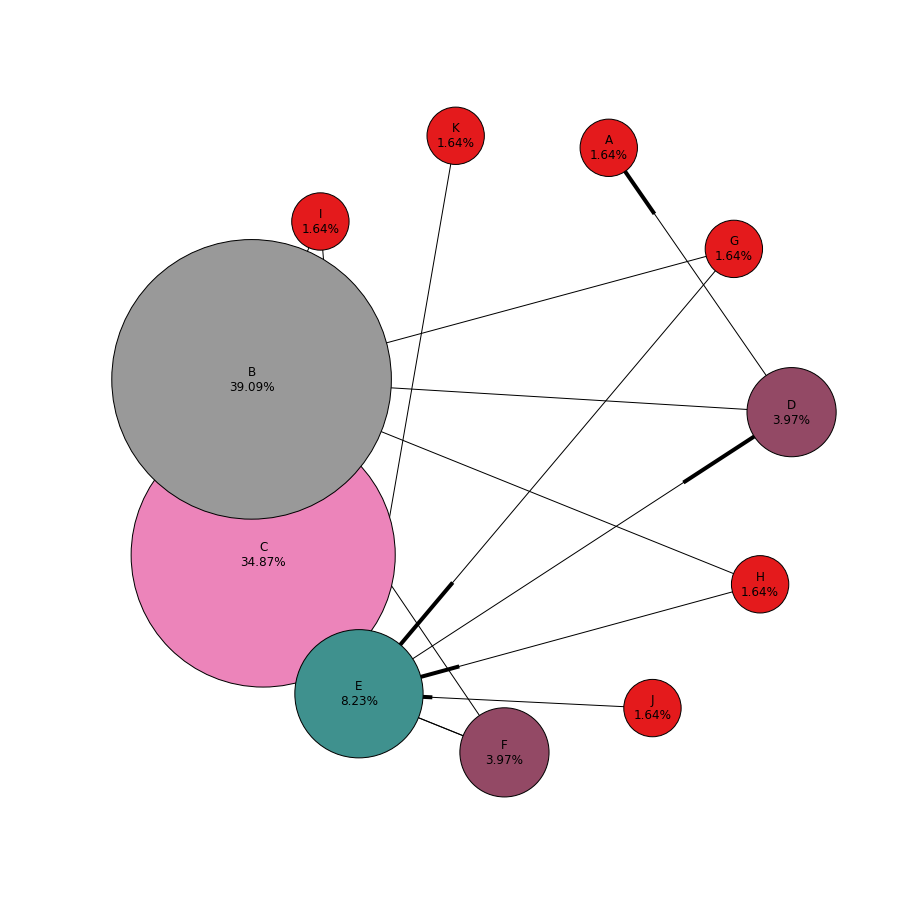

In [205]:
draw_graph()

In [206]:
!python driver91.py 1.0

Damping Factor 1.00


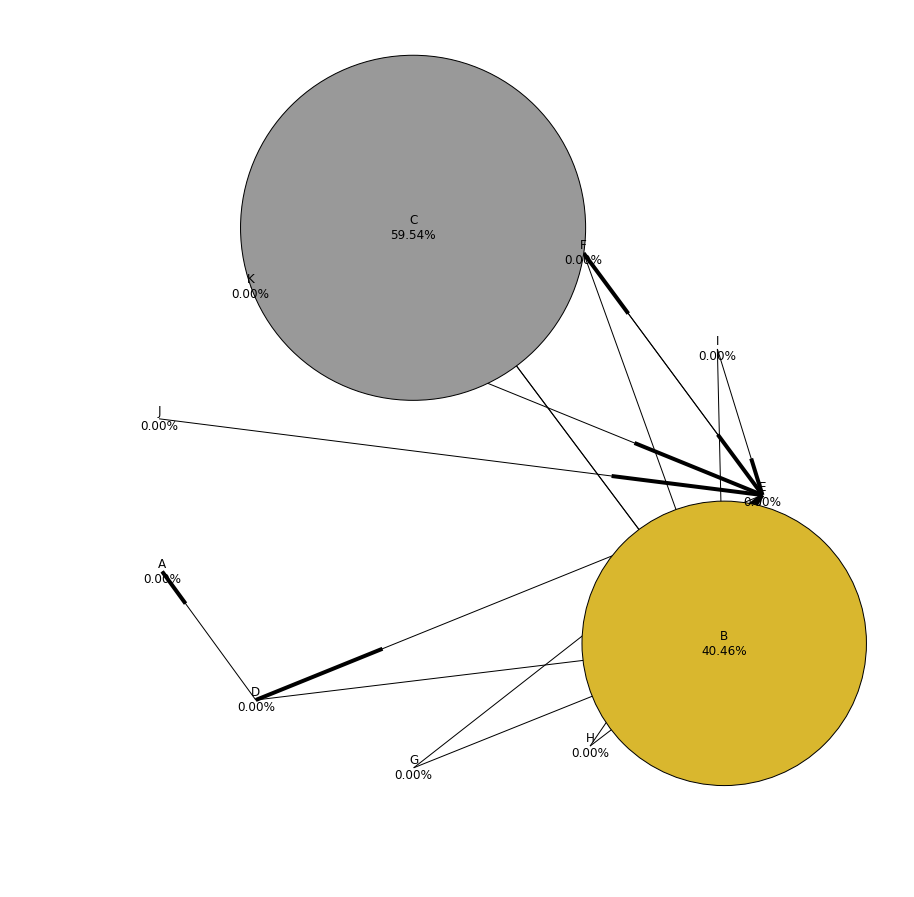

In [207]:
draw_graph()

## HW 9.3: Applying PageRank to the Wikipedia hyperlinks network

Run your PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

Run your PageRank implementation on the Wikipedia dataset for 50 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 
Have the top 100 ranked pages changed? Comment on your findings. Plot the pagerank values for the top 100 pages resulting from the 50 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  

In [ ]:
from MrJobTransform91 import MrJobTransform91
              
def transform(qfile):
    mr_job = MrJobTransform91(args=[qfile,
                                    '-r','hadoop',
                                    '--output-dir','hdfs:///user/rcordell/wikiout/'])
#                              '-r', 'emr',
#                              '--output-dir', 's3://w261-rlc-hw9/wikiout/'])

    with mr_job.make_runner() as runner:
        runner.run()
        counters = runner.counters()
        print 'Node Count: {0}'.format(counters[0]['transformer']['nodes'])

        
if __name__ == '__main__':
#    transform('s3://w261-rlc-hw9/in/all-pages-indexed-out.txt')
    transform('hdfs:///user/rcordell/all-pages-indexed-out.txt')

## HW 9.4: Topic-specific PageRank implementation using MRJob

Modify your PageRank implementation to produce a topic specific PageRank implementation,
as described in:

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.
This caveat lies in footnote 3 on page 3:

	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.

and must be adhered to for convergence to be guaranteed.

Run topic specific PageRank on the following randomly generated network of 100 nodes:

s3://ucb-mids-mls-networks/randNet.txt (also available on Dropbox)

which are organized into ten topics, as described in the file:

s3://ucb-mids-mls-networks/randNet_topics.txt  (also available on Dropbox)

Since there are 10 topics, your result should be 11 PageRank vectors
(one for the vanilla PageRank implementation in 9.1, and one for each topic
with the topic specific implementation). Print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result. 
Assume a teleportation factor of 0.15 in all your analyses.

One final and important comment here:  please consider the 
requirements for irreducibility with topic-specific PageRank.
In particular, the literature ensures irreducibility by requiring that
nodes not reachable from in-topic nodes be removed from the network.

This is not a small task, especially as it it must be performed
separately for each of the (10) topics.

So, instead of using this method for irreducibility, 
please comment on why the literature's method is difficult to implement,
and what what extra computation it will require.
Then for your code, please use the alternative, 
non-uniform damping vector:

vji = beta*(1/|Tj|); if node i lies in topic Tj

vji = (1-beta)*(1/(N - |Tj|)); if node i lies outside of topic Tj

for beta in (0,1) close to 1. 

With this approach, you will not have to delete any nodes.
If beta > 0.5, PageRank is topic-sensitive, 
and if beta < 0.5, the PageRank is anti-topic-sensitive. 
For any value of beta irreducibility should hold,
so please try beta=0.99, and perhaps some other values locally,
on the smaller networks.

## HW 9.5: Applying topic-specific PageRank to Wikipedia

Here you will apply your topic-specific PageRank implementation to Wikipedia,
defining topics (very arbitrarily) for each page by the length (number of characters) of the name of the article mod 10,
so that there are 10 topics. Once again, print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result.
Assume a teleportation factor of 0.15 in all your analyses.

## HW 9.6: TextRank (OPTIONAL)

What is TextRank. Describe the main steps in the algorithm. Why does TextRank work?
Implement TextRank in MrJob for keyword phrases (not just unigrams) extraction using co-occurrence based similarity measure with with sizes of N = 2 and 3. And evaluate your code using the following example using precision, recall, and FBeta (Beta=1):

"Compatibility of systems of linear constraints over the set of natural numbers
Criteria of compatibility of a system of linear Diophantine equations, strict 
inequations, and nonstrict inequations are considered. Upper bounds for
components of a minimal set of solutions and algorithms of construction of 
minimal generating sets of solutions for all types of systems are given. 
These criteria and the corresponding algorithms for constructing a minimal 
supporting set of solutions can be used in solving all the considered types of 
systems and systems of mixed types." 

The extracted keywords should in the following set:

linear constraints, linear diophantine equations, natural numbers, non-strict inequations, strict inequations, upper bounds

==================END HW 9==================
============================================